In [11]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'histopathologic-cancer-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F11848%2F862157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T080324Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D38fb0ad593bd0392d07a6ccc4e63bd0c6c683e8034b7f31457d97c7141f0b22effdb57b994ad7deaea8a048cd2cd80034380e71533b8e357bf6b1ee73b05bfa1405560682078e1f587e916f938527a1a94922f3866aa07aab377ce83e622373388d3717c92a796f01fbb2ccff097902079d40635be8765ab80e2f89e149a5a012e4e9403005ed39606d243b4e0063ed20bcab5add1c81688ced2cc31ad236ed4ba5b20e1e12384115b39d52d5b54592aab0dc5e88b306441bfeccfe03119c9681066ee2f94c373eaca59fd9858dc5b139deb827f5bf3c25ff7cee28bac71fe5ae8544e186917526477646af0846815e5d31a85435f2151e37abf08257eba7b55'

KAGGLE_INPUT_PATH='kaggle/input'
KAGGLE_WORKING_PATH='kaggle/working'
KAGGLE_SYMLINK='kaggle'

os.makedirs(KAGGLE_SYMLINK)
os.makedirs(KAGGLE_INPUT_PATH, 0o777)
os.makedirs(KAGGLE_WORKING_PATH, 0o777)

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[================================================= ] 6682951680 bytes downloaded
Downloaded and uncompressed: histopathologic-cancer-detection
Data source import complete.


In [12]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim 
from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from PIL import Image

## Loading of training and validation datasets

In [14]:
print(os.listdir("./kaggle/input/histopathologic-cancer-detection"))

['train_labels.csv', 'test', 'train', 'sample_submission.csv']


In [15]:
train_labels = pd.read_csv('./kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(train_labels.head())

#  Divide the train DataFrame into training and validation sets.
train_data, val_data = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=train_labels['label'])


print(f"Training size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Training size: 176020
Validation size: 44005


## Preview Data

label
0    104726
1     71294
Name: count, dtype: int64


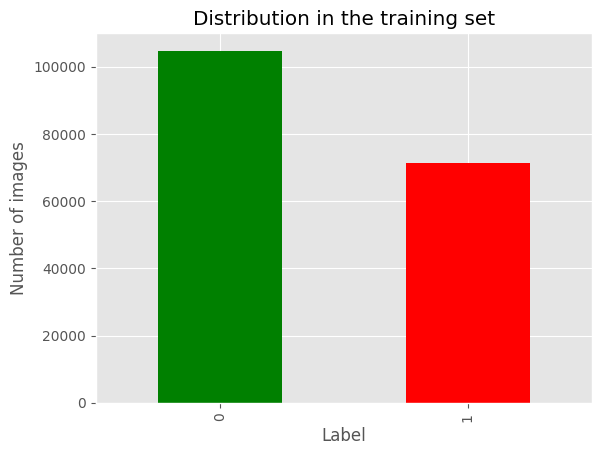

label
0    26182
1    17823
Name: count, dtype: int64


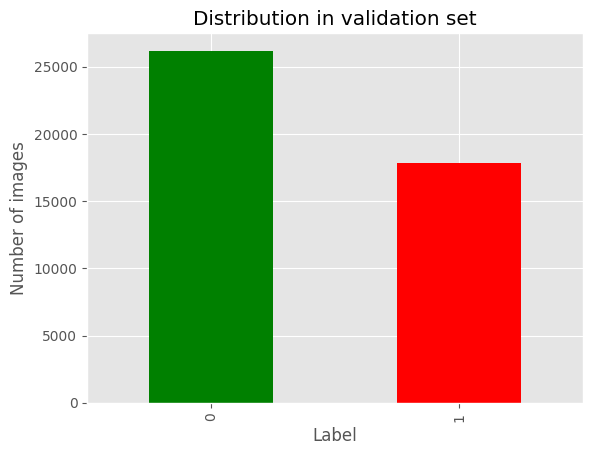

In [16]:
print(train_data['label'].value_counts())
train_data['label'].value_counts().plot(kind='bar',color=['green', 'red'])
plt.title('Distribution in the training set')
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.show()

print(val_data['label'].value_counts())
val_data['label'].value_counts().plot(kind='bar',color=['green', 'red'])
plt.title('Distribution in validation set')
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.show()

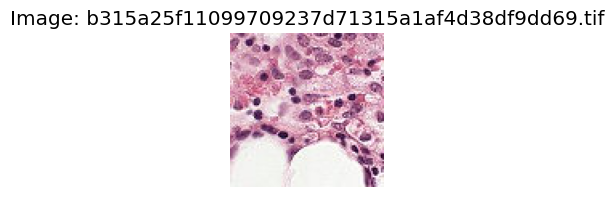

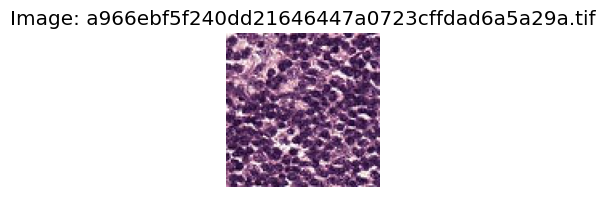

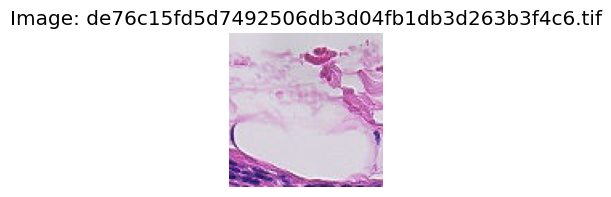

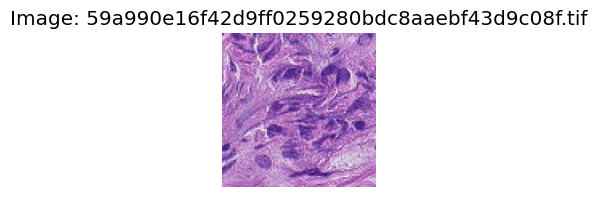

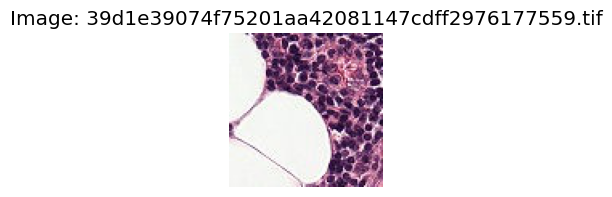

In [29]:
train_dir = './kaggle/input/histopathologic-cancer-detection/train/'
image_files = os.listdir(train_dir)

for img_file in image_files[:5]:  
    img_path = os.path.join(train_dir, img_file)
    
    img = Image.open(img_path)
    plt.figure(figsize=(4, 2))
    plt.imshow(img)
    plt.title(f'Image: {img_file}')
    plt.axis('off')
    plt.show()

## Dataset and DataLoader Creation

In [30]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((96, 96)),  
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# Create dataset to associate images and tags
class CancerImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe 
        self.img_dir = img_dir     
        self.transform = transform 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]['id']  
        label = self.dataframe.iloc[idx]['label']  
        img_path = os.path.join(self.img_dir, img_id + '.tif')
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [31]:
img_dir = "./kaggle/input/histopathologic-cancer-detection/train" 
train_dataset = CancerImageDataset(dataframe=train_data, img_dir=img_dir, transform=transform)
val_dataset= CancerImageDataset(dataframe=val_data, img_dir=img_dir, transform=transform)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image ID: f38a6374c348f90b587e046aac6079959adf3835, Label: 0


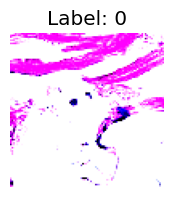

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image ID: c18f2d887b7ae4f6742ee445113fa1aef383ed77, Label: 0


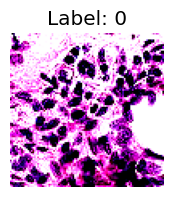

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image ID: 755db6279dae599ebb4d39a9123cce439965282d, Label: 0


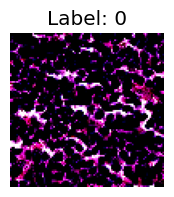

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image ID: bc3f0c64fb968ff4a8bd33af6971ecae77c75e08, Label: 0


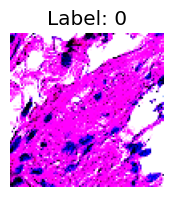

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image ID: 068aba587a4950175d04c680d38943fd488d6a9d, Label: 1


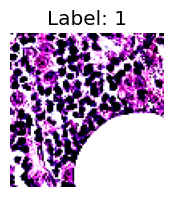

In [32]:
for i in range(5):
    img, label = train_dataset[i]
    print(f"Image ID: {train_labels.iloc[i]['id']}, Label: {label.item()}")
    
    plt.figure(figsize=(4, 2))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Label: {label.item()}")
    plt.axis('off')
    plt.show()

### Reduce dataset size due to performance constraint

In [33]:
import random

random.seed(42)
train_size = len(train_dataset)
val_size = len(val_dataset)

train_sample_size = int(train_size * 0.5)
val_sample_size = int(val_size * 0.5)

train_indexs = random.sample(range(train_size), train_sample_size)
val_indexs = random.sample(range(val_size), val_sample_size)
train_subset = Subset(train_dataset, train_indexs)
val_subset = Subset(val_dataset, val_indexs)
train_dataset = train_subset
val_dataset = val_subset


### DataLoaders creation

In [34]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## Convolutional neural network implementation

In [35]:
# Define convolutional neural network model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  
        self.fc1 = nn.Linear(32 * 24 * 24, 128)  
        self.dropout = nn.Dropout(p=0.5)  
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 24 * 24)  
        x = F.relu(self.fc1(x))  
        x = self.dropout(x)  
        x = self.fc2(x)  
        return x

model = CNN()

In [36]:
#  Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()  

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

## Model training

In [38]:
# Initialization of lists to store losses and precision
loss_list = []
accuracy_list = []

# Model training
num_epochs = 10 

for epoch in range(num_epochs):
    running_loss = 0.0  
    for i, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
            
    # Calculate accuracy
    correct = 0
    total = 0
    
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_outputs = model(val_images)
            predicted = torch.argmax(val_outputs.data, dim=1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item() 

    accuracy = 100 * correct / float(total)

    # Storing loss and accuracy
    loss_list.append(running_loss / len(train_dataloader))
    accuracy_list.append(accuracy)  
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_dataloader):.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/10], Training Loss: 0.1721, Accuracy: 86.46%
Epoch [2/10], Training Loss: 0.1574, Accuracy: 86.26%
Epoch [3/10], Training Loss: 0.1473, Accuracy: 85.98%
Epoch [4/10], Training Loss: 0.1320, Accuracy: 84.60%
Epoch [6/10], Training Loss: 0.1174, Accuracy: 84.57%
Epoch [7/10], Training Loss: 0.1130, Accuracy: 86.12%
Epoch [9/10], Training Loss: 0.0998, Accuracy: 85.76%
Epoch [10/10], Training Loss: 0.0961, Accuracy: 85.13%


## Model testing

In [40]:
class CancerTestDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_files_list = sorted(os.listdir(data_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = self.image_files_list[idx]
        img_path = os.path.join(self.data_folder, img_name)
        image = Image.open(img_path)
    
        if self.transform:
            image = self.transform(image)
        img_id = img_name.split('.')[0]
        return image, img_id

test_dataset = CancerTestDataset(
    data_folder='./kaggle/input/histopathologic-cancer-detection/test/',
    transform=transform
)

In [41]:
random.seed(42)
test_size = len(test_dataset)
test_sample_size = int(test_size * 0.5)
test_indexs = random.sample(range(test_size), test_sample_size)
test_subset = Subset(test_dataset, test_indexs)

test_dataset = test_subset

In [42]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)  

In [ ]:
model.eval()
preds = []
image_ids = []
with torch.no_grad():
    for inputs, img_ids in test_dataloader:
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs[:, 1]) 
        probabilities = probabilities.numpy()
        preds.extend(probabilities)
        image_ids.extend(img_ids)

submission = pd.DataFrame({'id': image_ids, 'label': preds})
submission['label'] = submission['label'].clip(0, 1)
submission.to_csv('./kaggle/working/submission.csv', index=False)

print(submission.head())